### Use the Asynchronous Advantage Actor Critic (A3C) Policy Gradient Method to solve Breakout

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import progressbar as pb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

from torchsummary import summary

In [2]:
env_id = 'BreakoutDeterministic-v4'
env = gym.make(env_id)

In [3]:
env.observation_space

Box(210, 160, 3)

In [4]:
print(f"Actions:{env.action_space}\nMeanings:{env.unwrapped.get_action_meanings()}")

Actions:Discrete(4)
Meanings:['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #convert to GPU if available

## Preprocess Image

In [6]:
## Utils
def preprocess_single_frame(image, bkg_color = np.array([144, 72, 17])):
    """
    Converts an image from RGB channel to B&W channels.
    Also performs downscale to 80x80. Performs normalization.
    @Param:
    1. image: (array_like) input image. shape = (210, 160, 3)
    2. bkg_color: (np.array) standard encoding for brown in RGB with alpha = 0.0
    @Return:
    - img: (array_like) B&W, downscaled, normalized image of shape (80x80)
    """
    img = np.mean(image[35:195:2,::2]-bkg_color, axis=-1)/255.
    return img

#Utils
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    """
    convert outputs of parallelEnv to inputs to pytorch neural net"""
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

In [7]:
state = env.reset()
for _ in range(20):#skip 20 frames
    frame, _, _, _ = env.step(np.random.randint(0, env.action_space.n))

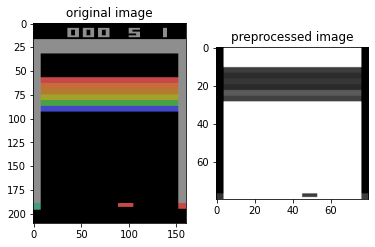

In [8]:
#Plot processed and raw image
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(preprocess_single_frame(frame), cmap='Greys')
plt.show()

# Actor-Critic

<img height=500 width=500 src="https://www.mdpi.com/energies/energies-09-00725/article_deploy/html/images/energies-09-00725-g001-1024.png">

In [96]:
class ActorCritic(nn.Module):
    def __init__(self, action_size=4, num_frames=2):
        super(ActorCritic, self).__init__()
        self.action_size = action_size
        
        #Define the CNN for Actor & Critic
        self.conv1 = nn.Conv2d(num_frames, 32, 3, stride=2, padding=1) #output = 40x40x32
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 20x20x32
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 10x10x32
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1) #output = 5x5x32
        
        self.size = 5*5*32 #800

        #FC layer
        self.lstm = nn.LSTMCell(input_size=self.size, hidden_size=512)#lstm cell to prevent vanishing gradients
        
        # Define Actor and Critic network
        # Critic evaluates the state value function, V(π) using TD estimate.
        # Actor evaluates the policy π(a|s) distribution
        
        self.critic_linear, self.actor_linear = nn.Linear(512, 1), nn.Linear(512, self.action_size)
        
    def forward(self, x, hx, cx):
        """
        Peforms one-pass for the Conv layers.
        @Param:
        1. x - shape: (2, 80, 80); 2 stacked frames of 80x80 images
        2. hx - hidden state of the RNN. shape: (800x512)
        3. cx - confidence state of the RNN. shape: (800x512)
        @Return:
        1. critic estimated value, V(π)
        2. actor policy distribution, π(a|s) as logits
        """
        #4 conv nets without max pool layers, simple Relu activation f(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        print(x.shape)
        x = x.view(-1,self.size) #flatten
        print(x.shape)
        hx, cx = self.lstm(x, (hx, cx)) #dynamic calculation for final confidence & hidden state
        value = self.critic_linear(hx) #CRITIC: calculates estimated state value function, V(π)
        logits = self.actor_linear(hx) #ACTOR:  calculates policy distribution π(a|s)
        
        return logits, value, hx, cx

In [97]:
agent = ActorCritic()

# Optimizer
<p> A critical component to an A3C model is the ability to share parameters across
    multiple agents running asynchronously such that they can collectively learn from
    each other. This is done by the cross-integration (sharing) of gradients across all processes.
</p>

In [101]:
class SharedOptimizer(optim.Adam):
    """Implementation of shared parameter model using Adam optimizer"""
    def __init__(self, params, lr=0.001):
        super(SharedOptimizer, self).__init__(params)
        #TODO

In [102]:
optimizer = SharedOptimizer(agent.parameters())

In [78]:
[np.array(param[0]['params'])[i].shape for i in range(16)]

[torch.Size([32, 2, 3, 3]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([32, 32, 3, 3]),
 torch.Size([32]),
 torch.Size([2048, 800]),
 torch.Size([2048, 512]),
 torch.Size([2048]),
 torch.Size([2048]),
 torch.Size([1, 512]),
 torch.Size([1]),
 torch.Size([4, 512]),
 torch.Size([4])]